In [406]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utilities import *

In [407]:
min_max = MinMaxScaler()

# Load Data

In [408]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv").merge(pd.read_csv("./data/sample_submission.csv"), how="inner")

In [409]:
y_train = train["SalePrice"]
x_train = train.drop(columns = ["SalePrice"])

In [410]:
y_test = test["SalePrice"]
x_test = test.drop(columns = ["SalePrice"])

In [411]:
categorical_variables = x_train.select_dtypes(include=object)

In [412]:
numerical_variables = getNumericalColumns(x_train)
numerical_variables_normalized = pd.DataFrame(min_max.fit_transform(numerical_variables), columns=numerical_variables.columns)

# Remove unnecesary columns

In [413]:
num_of_nulls = x_train.isna().sum()
percentage_of_nulls = num_of_nulls/x_train.shape[0]
percentage_of_nulls.sort_values(ascending=False, inplace=True)
percentage_of_nulls.apply(lambda x: f"{x*100:.3f}%").head(10)

PoolQC         99.521%
MiscFeature    96.301%
Alley          93.767%
Fence          80.753%
MasVnrType     59.726%
FireplaceQu    47.260%
LotFrontage    17.740%
GarageCond      5.548%
GarageType      5.548%
GarageYrBlt     5.548%
dtype: object

In [414]:
null_threshold = 0.4
null_columns = percentage_of_nulls.loc[percentage_of_nulls > null_threshold]
null_columns = null_columns.index.to_list()
null_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

<Axes: >

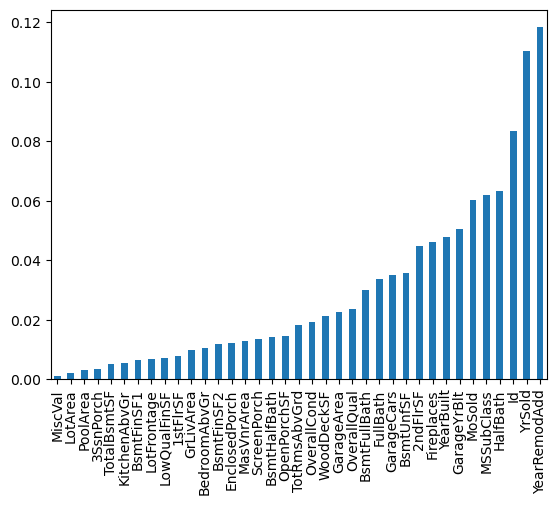

In [415]:
variance = numerical_variables_normalized.var()
variance.sort_values().plot(kind="bar")

In [416]:
variance_threshold = 0.005
low_variance_columns = variance.loc[variance < variance_threshold]
low_variance_columns = low_variance_columns.index.to_list()
low_variance_columns

['LotArea', '3SsnPorch', 'PoolArea', 'MiscVal']

In [417]:
columns_to_remove = [*null_columns, *low_variance_columns, 'Id']
def preprocessing(df: pd.DataFrame):
    df = df.drop(columns = df.columns.join(columns_to_remove, how='inner'))
    for col in df.columns:
        if df[col].dtype in (np.int64, np.float64):
            df[col] = min_max.fit_transform(df[col].values.reshape(-1,1))
    return df

# Preprocessing Test

In [418]:
x_train = fillNans(getNumericalColumns(x_train))
x_test = fillNans(getNumericalColumns(x_test))

In [419]:
x_train_preprocessed = preprocessing(x_train)
x_test_preprocessed = preprocessing(x_test)

In [420]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

clf = DecisionTreeRegressor()

In [421]:
MSE = []
for _ in range(100):
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    MSE.append(mean_absolute_error(y_test, prediction))
print(np.mean(MSE))

58079.73965502676


In [422]:
MSE = []
for _ in range(100):
    clf.fit(x_train_preprocessed, y_train)
    prediction = clf.predict(x_test_preprocessed)
    MSE.append(mean_absolute_error(y_test, prediction))
print(np.mean(MSE))

54428.898096115096
